# Домашнее задание №4

## 2. Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на губы(т.е. 2 класса: губы/не губы).


### Подключение библиотек и загрузка датасета

In [1]:
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F
import numpy as np

In [2]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 245kB 9.0MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=675f2b1c25f15d66bdee6476b506e5c2dec1336dd5182e0dcd00e9097ea46e2d
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12420 sha256=71974b0a34f2b88dd615234e9c97951abb0288ea7b0e1d2ad81ea5959b356cd3
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch


In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d olekslu/makeup-lips-segmentation-28k-samples
!unzip /content/makeup-lips-segmentation-28k-samples.zip -d /content/lips_dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/lips_dataset/set-lipstick-original/mask/mask00023595.png  
  inflating: /content/lips_dataset/set-lipstick-original/mask/mask00023596.png  
  inflating: /content/lips_dataset/set-lipstick-original/mask/mask00023597.png  
  inflating: /content/lips_dataset/set-lipstick-original/mask/mask00023598.png  
  inflating: /content/lips_dataset/set-lipstick-original/mask/mask00023599.png  
  inflating: /content/lips_dataset/set-lipstick-original/mask/mask00023600.png  
  inflating: /content/lips_dataset/set-lipstick-original/mask/mask00023601.png  
  inflating: /content/lips_dataset/set-lipstick-original/mask/mask00023602.png  
  inflating: /content/lips_dataset/set-lipstick-original/mask/mask00023603.png  
  inflating: /content/lips_dataset/set-lipstick-original/mask/mask00023604.png  
  inflating: /content/lips_dataset/set-lipstick-original/mask/mask00023605.png  
  inflating: /content/lips_dataset/set-li

In [5]:
# Здесь имена файлов не бьют с теми, что лежат в папке, поэтому надо самим сгенерировать пути файлов
df = pd.read_csv('./lips_dataset/set-lipstick-original/list.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


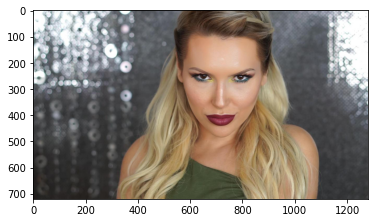

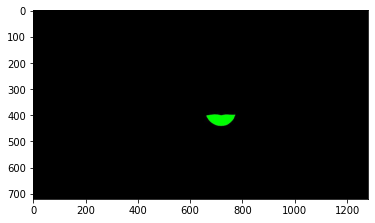

In [6]:
img = plt.imread('./lips_dataset/set-lipstick-original/720p/image00000001.jpg')
plt.imshow(img)
plt.show()
# Второй рисунок - ьрехканальное изображение - надо перевести в одноканальное (так как 1 класс)
mask = plt.imread('./lips_dataset/set-lipstick-original/mask/mask00000001.png')
plt.imshow(mask)
plt.show()

### Описание пайплайна преобразования масок (будет реализован в классе)

In [7]:
mask = plt.imread('./lips_dataset/set-lipstick-original/mask/mask00000002.png')
# Маски 3-канальные, нужно преобразовать в один канал и так,
# чтобы было только 2 возможных значения в тензоре (0 и 1)
mask.shape

(720, 1280, 3)

In [8]:
mask_channels = [mask[:,:,0], mask[:,:,1], mask[:,:,2]]

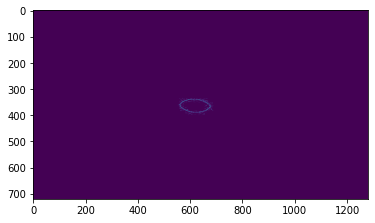

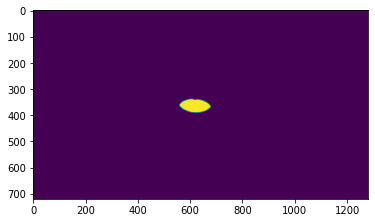

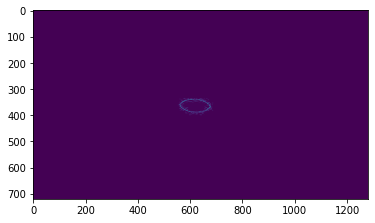

In [9]:
# Выведем 3 цветовых канала (видно, что зеленого больше всего)
for mask_channel in mask_channels:
    plt.imshow(mask_channel)
    plt.show()

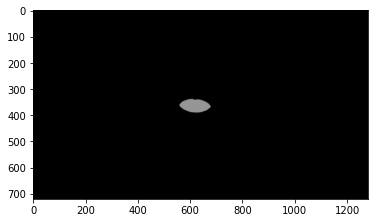

In [10]:
# Преобразование в оттенки серого
mask = Image.open('./lips_dataset/set-lipstick-original/mask/mask00000002.png').convert('LA')
plt.imshow(mask)
plt.show()

In [11]:
mask = np.asarray(mask).astype('float')[:,:,0]
mask.shape

(720, 1280)

In [12]:
np.unique(mask)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  51.,  52.,  53.,  54.,  56.,  58.,
        59.,  60.,  62.,  63.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  84.,
        85.,  87.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
       102., 103., 104., 105., 108., 109., 114., 116., 117., 118., 119.,
       120., 121., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.,
       166., 167., 168., 169., 170., 173., 178.])

In [13]:
# Вводим пороговую функцию, чтобы было только 2 значения (губы и фон)
mask = np.where(mask > 100, 1.0, 0)
np.unique(mask)

array([0., 1.])

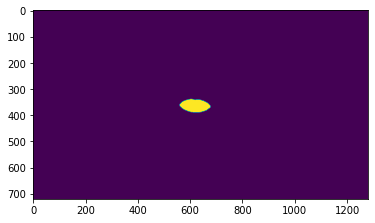

In [14]:
plt.imshow(mask)
plt.show()

### Подготовка данных для датасета

In [15]:
# Адреса картинок, которые по факту есть в директории
image = []
image_mask = []
for root, dirs, files in os.walk('./lips_dataset'):
    for name in files:
        f = os.path.join(root, name)
        if 'image' in f:
            image.append(f)
        elif 'mask' in f:
            image_mask.append(f)
        else:
            break

In [16]:
# Проблема: неравное количество картинок и соответствующих им масок в списках, полученных при
# обходе дерева каталогов
print(len(image))
print(len(image_mask))

28594
28540


In [17]:
# В df получаем полные адреса картинок, которые перечислены в нем
df['filename'] = df['filename'].apply(lambda x: './lips_dataset/set-lipstick-original/720p/' + x)
df['mask'] = df['mask'].apply(lambda x: './lips_dataset/set-lipstick-original/mask/' + x)

In [18]:
print(len(df['filename']))

28594


In [19]:
# Проблема 2: при обучении с использованием адресов в df были адреса, по котором не существовали
# реальные картинки. Поэтому нужно удалить из df те адреса, которых нет в списках image и image_mask
df = df[df['filename'].isin(image)] 
df = df[df['mask'].isin(image_mask)]

In [20]:
print(len(df['filename']))

28540


### Класс для кастомного датасета

In [21]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,8]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (H, W, 3) -> (1, H, W, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, H, W, 3) -> (1, 3, H, W)
        img = img.unsqueeze(0).permute(0,3,1,2)

        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с HхW на 256х256
        # clamp не позволяет выйти за границы
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic').clamp(min=0, max=1)
        
        # Читаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        mask = Image.open(self.label_arr[index]).convert('LA') # преобразование в серый
        mask = np.asarray(mask).astype('float')[:,:,0]
        mask = torch.as_tensor(np.where(mask > 100, 1.0, 0)).unsqueeze(0) # введение порога и нормализация
        mask = mask.unsqueeze(0)
        mask = mask.float()
        # делаем ресайз картинки на 256х256
        mask = F.interpolate(input=mask, size=256, mode='nearest')
        
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

### Разделение на тренировочную и тестовую выборки

In [22]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [44]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=16,shuffle=False)

### Проверка работы загрузчика

In [24]:
loader = iter(train_data_loader)
img, mask = loader.next()

In [25]:
img.shape

torch.Size([1, 1, 3, 256, 256])

In [26]:
mask.shape

torch.Size([1, 1, 1, 256, 256])

In [27]:
mask[0].shape

torch.Size([1, 1, 256, 256])

In [28]:
torch.unique(mask[0])

tensor([0., 1.])

In [29]:
np.unique(img).min()

0.0

In [30]:
np.unique(img).max()

1.0

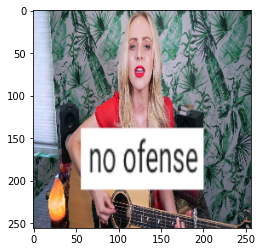

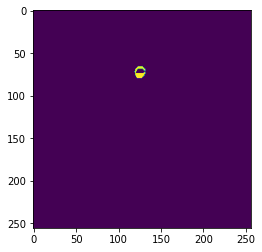

In [31]:
plt.imshow((img[0][0]).permute(1, 2, 0))
plt.show()
plt.imshow((mask[0][0][0]))
plt.show()

### Создание класса модели

In [32]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

### Обучение

In [33]:
learning_rate = 0.001
epochs = 1

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [35]:
# Создание своей модели
Umodel = UNet(num_classes=1).to(device)

In [36]:
# Создание модели из segmentation_models_pytorch
Umodel = smp.Unet('mobilenet_v2', 
                  classes=1, 
                  encoder_weights='imagenet').to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [37]:
optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)

In [38]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [39]:
criterion = SoftDiceLoss()

In [40]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 19978 total_steps per epoch


Train Epoch: 1, Loss: 0.5122084464629492
Spend time for 300 images: 33.199808835983276 sec


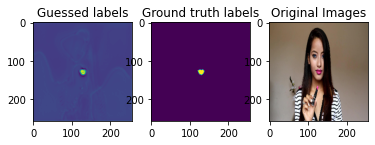

Train Epoch: 1, Loss: 0.1578576378027598
Spend time for 300 images: 33.79853367805481 sec


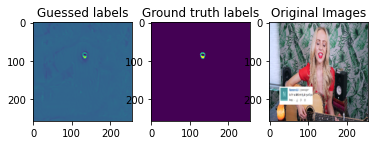

Train Epoch: 1, Loss: 0.11846192439397175
Spend time for 300 images: 33.7110800743103 sec


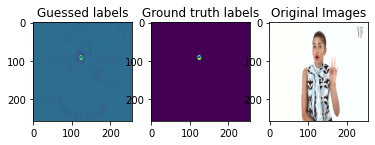

Train Epoch: 1, Loss: 0.09143576959768931
Spend time for 300 images: 33.64524292945862 sec


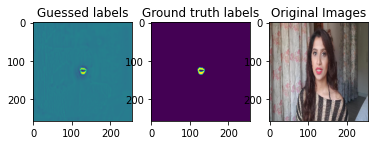

Train Epoch: 1, Loss: 0.0927838683128357
Spend time for 300 images: 33.30941891670227 sec


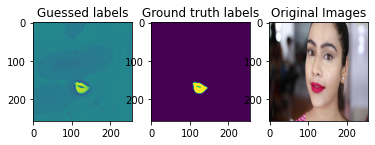

Train Epoch: 1, Loss: 0.0718526570002238
Spend time for 300 images: 33.230772972106934 sec


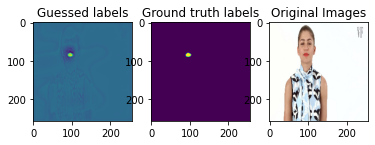

Train Epoch: 1, Loss: 0.08161229570706685
Spend time for 300 images: 32.798309326171875 sec


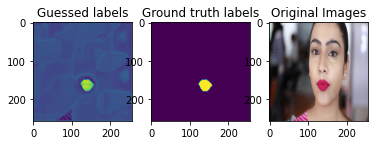

Train Epoch: 1, Loss: 0.08367126762866973
Spend time for 300 images: 32.22341322898865 sec


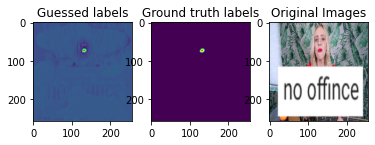

Train Epoch: 1, Loss: 0.07308828830718994
Spend time for 300 images: 32.16885328292847 sec


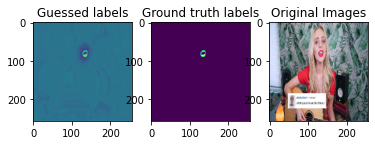

Train Epoch: 1, Loss: 0.0928995164235433
Spend time for 300 images: 32.287341594696045 sec


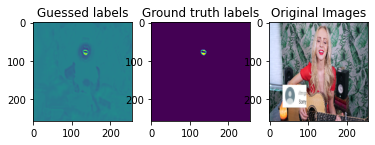

Train Epoch: 1, Loss: 0.08885657171408336
Spend time for 300 images: 32.43472909927368 sec


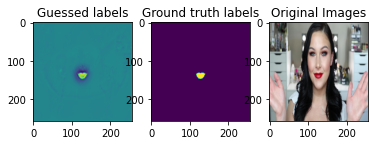

Train Epoch: 1, Loss: 0.07124469836552938
Spend time for 300 images: 33.317808628082275 sec


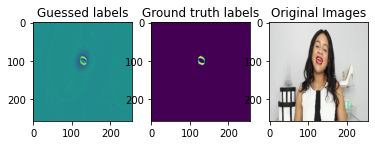

Train Epoch: 1, Loss: 0.06506543556849162
Spend time for 300 images: 33.23577547073364 sec


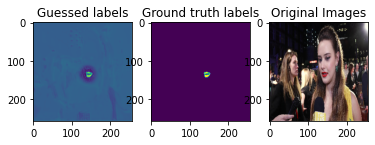

Train Epoch: 1, Loss: 0.08565219442049662
Spend time for 300 images: 33.54957365989685 sec


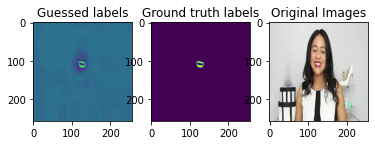

Train Epoch: 1, Loss: 0.05805754860242208
Spend time for 300 images: 33.37653350830078 sec


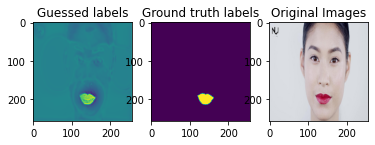

Train Epoch: 1, Loss: 0.052344201803207396
Spend time for 300 images: 33.474478244781494 sec


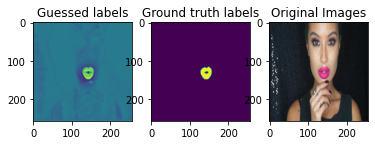

Train Epoch: 1, Loss: 0.05108298103014628
Spend time for 300 images: 33.341153621673584 sec


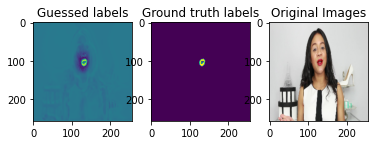

Train Epoch: 1, Loss: 0.04958735624949137
Spend time for 300 images: 33.290202617645264 sec


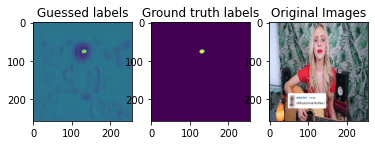

Train Epoch: 1, Loss: 0.06640854855378468
Spend time for 300 images: 33.43013668060303 sec


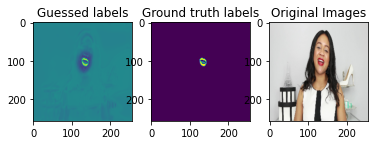

Train Epoch: 1, Loss: 0.052316795587539676
Spend time for 300 images: 33.142619132995605 sec


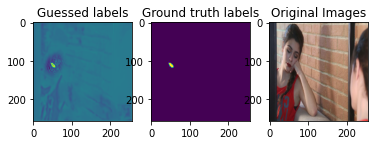

Train Epoch: 1, Loss: 0.048219950397809345
Spend time for 300 images: 33.13919734954834 sec


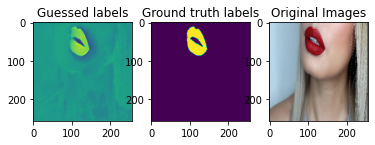

Train Epoch: 1, Loss: 0.06208083788553874
Spend time for 300 images: 33.3464789390564 sec


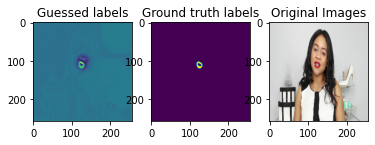

Train Epoch: 1, Loss: 0.0891044815381368
Spend time for 300 images: 33.10500168800354 sec


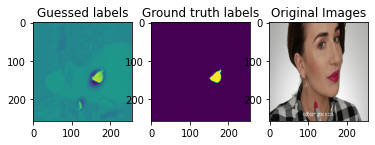

Train Epoch: 1, Loss: 0.05335860113302866
Spend time for 300 images: 33.53623914718628 sec


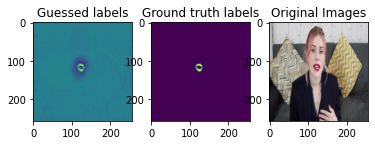

Train Epoch: 1, Loss: 0.0588190758228302
Spend time for 300 images: 34.2665901184082 sec


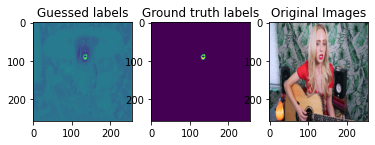

Train Epoch: 1, Loss: 0.05467779020468394
Spend time for 300 images: 34.33563494682312 sec


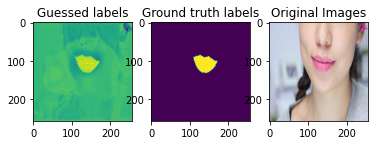

Train Epoch: 1, Loss: 0.05555600126584371
Spend time for 300 images: 33.55945706367493 sec


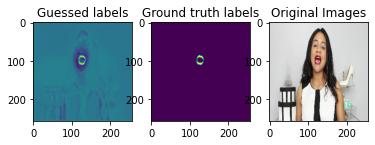

Train Epoch: 1, Loss: 0.045076695084571836
Spend time for 300 images: 33.779247522354126 sec


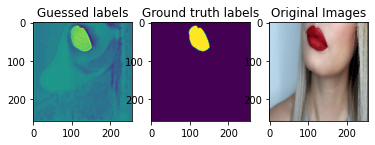

Train Epoch: 1, Loss: 0.04165796458721161
Spend time for 300 images: 33.793763637542725 sec


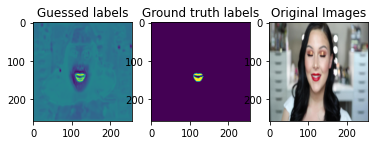

Train Epoch: 1, Loss: 0.048017573952674864
Spend time for 300 images: 33.75560903549194 sec


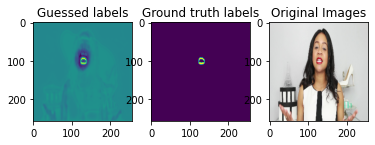

Train Epoch: 1, Loss: 0.044949127833048504
Spend time for 300 images: 33.52069973945618 sec


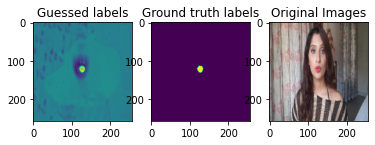

Train Epoch: 1, Loss: 0.04453293482462565
Spend time for 300 images: 33.61630940437317 sec


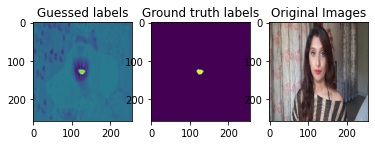

Train Epoch: 1, Loss: 0.041717247366905214
Spend time for 300 images: 33.58311891555786 sec


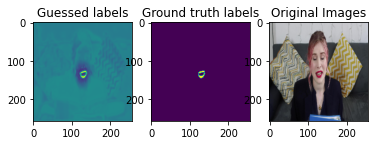

Train Epoch: 1, Loss: 0.050072286128997806
Spend time for 300 images: 33.43452215194702 sec


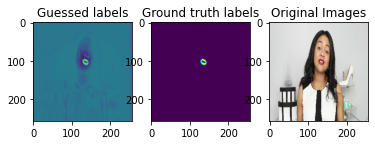

Train Epoch: 1, Loss: 0.05485346357027689
Spend time for 300 images: 33.42811989784241 sec


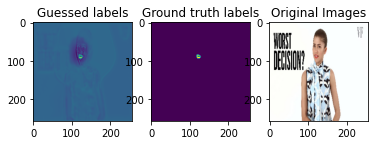

Train Epoch: 1, Loss: 0.0709480188290278
Spend time for 300 images: 33.28203558921814 sec


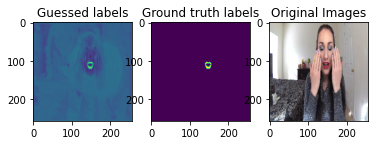

Train Epoch: 1, Loss: 0.06434696992238363
Spend time for 300 images: 33.32836699485779 sec


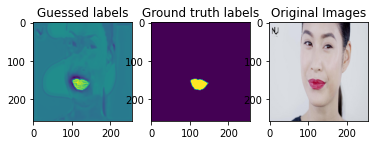

Train Epoch: 1, Loss: 0.1091885930299759
Spend time for 300 images: 33.38908505439758 sec


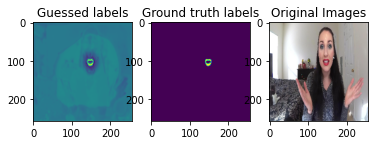

Train Epoch: 1, Loss: 0.06593196829160054
Spend time for 300 images: 33.387134075164795 sec


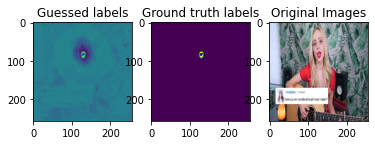

Train Epoch: 1, Loss: 0.052381676038106284
Spend time for 300 images: 33.324223279953 sec


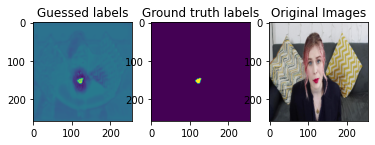

Train Epoch: 1, Loss: 0.04952886462211609
Spend time for 300 images: 33.37550067901611 sec


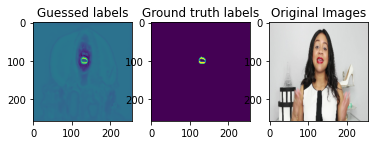

Train Epoch: 1, Loss: 0.04757708330949147
Spend time for 300 images: 33.574838399887085 sec


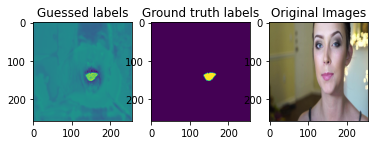

Train Epoch: 1, Loss: 0.05809555848439534
Spend time for 300 images: 33.48241877555847 sec


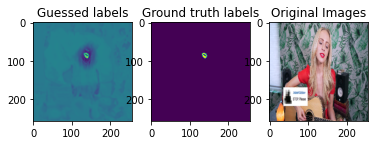

Train Epoch: 1, Loss: 0.04969605604807536
Spend time for 300 images: 33.464643478393555 sec


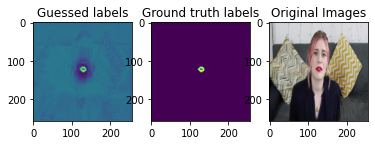

Train Epoch: 1, Loss: 0.06565882941087087
Spend time for 300 images: 33.08155083656311 sec


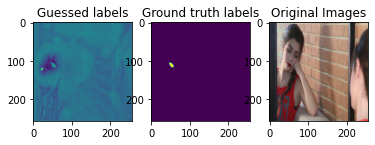

Train Epoch: 1, Loss: 0.0488806414604187
Spend time for 300 images: 33.236095905303955 sec


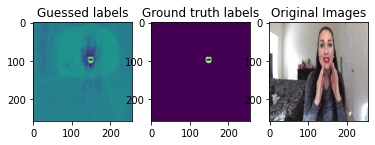

Train Epoch: 1, Loss: 0.04095277031262716
Spend time for 300 images: 32.95602107048035 sec


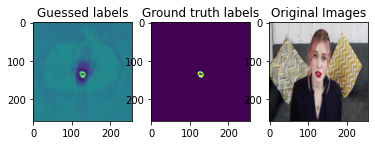

Train Epoch: 1, Loss: 0.04148344417413076
Spend time for 300 images: 33.04316020011902 sec


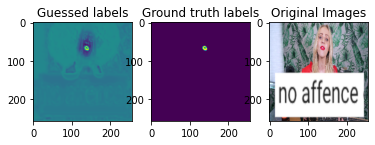

Train Epoch: 1, Loss: 0.05512362281481425
Spend time for 300 images: 32.91551446914673 sec


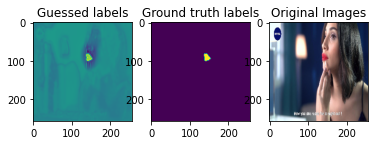

Train Epoch: 1, Loss: 0.044023858904838564
Spend time for 300 images: 33.21453833580017 sec


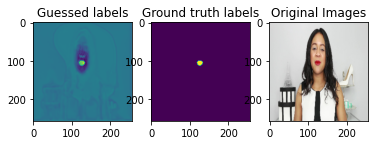

Train Epoch: 1, Loss: 0.042165225744247435
Spend time for 300 images: 33.50531792640686 sec


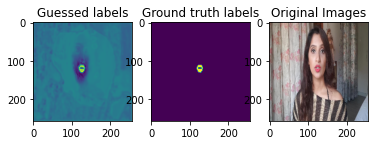

Train Epoch: 1, Loss: 0.04321099142233531
Spend time for 300 images: 33.3130829334259 sec


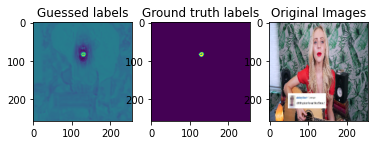

Train Epoch: 1, Loss: 0.04715699692567189
Spend time for 300 images: 33.2675199508667 sec


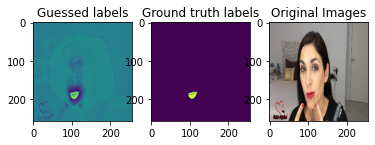

Train Epoch: 1, Loss: 0.04094491501649221
Spend time for 300 images: 33.48504042625427 sec


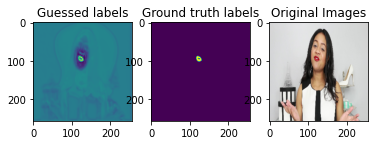

Train Epoch: 1, Loss: 0.041134107112884524
Spend time for 300 images: 33.394171714782715 sec


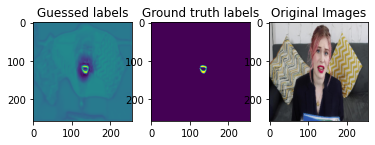

Train Epoch: 1, Loss: 0.03905679007371267
Spend time for 300 images: 33.36500525474548 sec


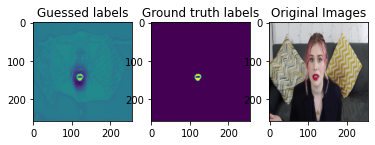

Train Epoch: 1, Loss: 0.041712319453557335
Spend time for 300 images: 33.11081385612488 sec


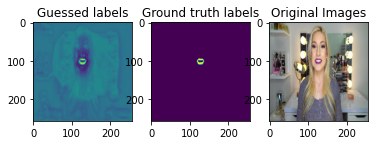

Train Epoch: 1, Loss: 0.044316881696383155
Spend time for 300 images: 32.94049525260925 sec


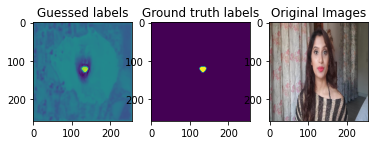

Train Epoch: 1, Loss: 0.037918440500895184
Spend time for 300 images: 32.99623513221741 sec


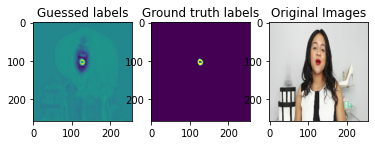

Train Epoch: 1, Loss: 0.04127697726090749
Spend time for 300 images: 33.16483783721924 sec


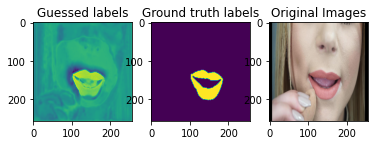

Train Epoch: 1, Loss: 0.03935727655887604
Spend time for 300 images: 33.09887218475342 sec


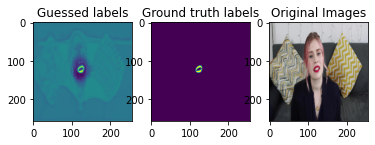

Train Epoch: 1, Loss: 0.03972594102223714
Spend time for 300 images: 33.23834228515625 sec


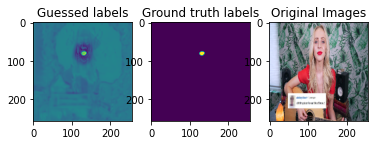

Train Epoch: 1, Loss: 0.04314270496368408
Spend time for 300 images: 33.145461559295654 sec


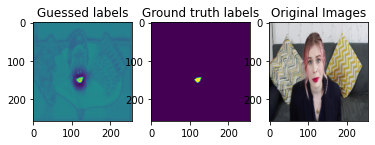

Train Epoch: 1, Loss: 0.04312734107176463
Spend time for 300 images: 33.15854287147522 sec


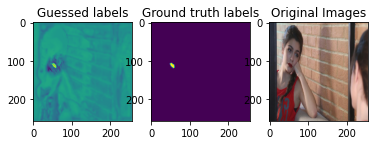

Train Epoch: 1, Loss: 0.03876157859961192
Spend time for 300 images: 33.15705943107605 sec


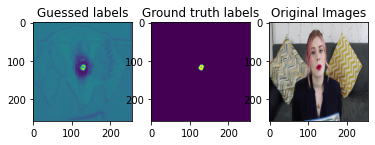

Train Epoch: 1, Loss: 0.04002708971500397
Spend time for 300 images: 33.049062967300415 sec


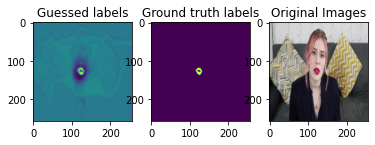

Epoch 1, loss:  0.06545038548290628


In [41]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss =0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
        data = data.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = Umodel(data[0])

        loss = criterion(outputs, labels[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 300 == 299:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/300}')
            time2 = time.time()
            print(f'Spend time for 300 images: {time2-time1} sec')
            time1 = time.time()
            running_loss = 0.0

            f, axarr = plt.subplots(1,3)
            #axarr[0].imshow(torch.argmax(outputs.detach().cpu().numpy()[0,:,:]))
            axarr[0].imshow(outputs.detach().cpu().numpy()[0, 0, :,:])
            axarr[0].set_title('Guessed labels')

            axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
            axarr[1].set_title('Ground truth labels')

            axarr[2].imshow(data[0].permute(0,2,3,1).detach().cpu().numpy()[0,:,:,:])
            axarr[2].set_title('Original Images')
            plt.show()

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

### Валидация на тестовой выборке

In [ ]:
total_steps = len(test_data_loader)
total_loss = 0.
with torch.no_grad():
    for data, labels in test_data_loader:
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()
        outputs = Umodel(data[0])
        loss = criterion(outputs, labels[0])
        total_loss += loss

In [56]:
print(f'Loss on test dataset: {(total_loss / total_steps).item():.4f}')

Loss on test dataset: 0.0392
